<a href="https://colab.research.google.com/github/Garima27dec/Emotion-Detection-with-Multiple-Data-Streams/blob/main/BERT_Text_Sentiment_Recognition.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import tensorflow_hub as hub

In [2]:
!pip install -U tensorflow-text==2.12.0
import tensorflow_text as text

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.0/6.0 MB 13.4 MB/s eta 0:00:00


In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
import os
import numpy as np
import pandas as pd
import cv2
import seaborn as sns
import shutil
import tensorflow as tf
import tensorflow.keras as keras
from keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from keras.layers import Dense, Embedding, LSTM,Dropout,TimeDistributed, Flatten, Bidirectional, Input
from sklearn.model_selection import train_test_split
from keras.utils.np_utils import to_categorical
from keras.models import Sequential, Model
import matplotlib.pyplot as plt
from keras.layers import BatchNormalization
from keras.regularizers import l2
from keras.losses import CategoricalCrossentropy
from keras.metrics import CategoricalAccuracy
import re

In [6]:
dataset = pd.read_csv('/content/drive/MyDrive/Emotion_Recognition/Text_ER/tweet_emotions.csv')

In [7]:
dataset.head()

,tweet_id,sentiment,content
0,1956967341,empty,@tiffanylue i know i was listenin to bad habi...
1,1956967666,sadness,Layin n bed with a headache ughhhh...waitin o...
2,1956967696,sadness,Funeral ceremony...gloomy friday...
3,1956967789,enthusiasm,wants to hang out with friends SOON!
4,1956968416,neutral,@dannycastillo We want to trade with someone w...


In [8]:
dataset = dataset.drop(['tweet_id'],axis=1)
dataset.head()

,sentiment,content
0,empty,@tiffanylue i know i was listenin to bad habi...
1,sadness,Layin n bed with a headache ughhhh...waitin o...
2,sadness,Funeral ceremony...gloomy friday...
3,enthusiasm,wants to hang out with friends SOON!
4,neutral,@dannycastillo We want to trade with someone w...


In [9]:
print(dataset['sentiment'].unique())

['empty' 'sadness' 'enthusiasm' 'neutral' 'worry' 'surprise' 'love' 'fun'
 'hate' 'happiness' 'boredom' 'relief' 'anger']


In [10]:
dataset['sentiment'].value_counts()

neutral       8638
worry         8459
happiness     5209
sadness       5165
love          3842
surprise      2187
fun           1776
relief        1526
hate          1323
empty          827
enthusiasm     759
boredom        179
anger          110
Name: sentiment, dtype: int64

In [11]:
dataset['sentiment'] = dataset['sentiment'].replace(["worry","happiness","sadness","love","surprise","fun","relief","hate","empty","enthusiasm", "boredom", "anger","neutral"], ["Fear","Happy","Sad","Happy","Surprise","Happy","Neutral","Disgust","Sad","Happy","Sad","Angry", "Neutral"])

In [12]:
dataset['sentiment'].value_counts()

Happy       11586
Neutral     10164
Fear         8459
Sad          6171
Surprise     2187
Disgust      1323
Angry         110
Name: sentiment, dtype: int64

In [13]:
X= dataset.drop('sentiment',axis=1)
y = dataset['sentiment']

In [14]:
X_train,X_val,y_train,y_val = train_test_split(X,y, test_size=0.25)

In [15]:
y_train.value_counts()

Happy       8737
Neutral     7578
Fear        6352
Sad         4605
Surprise    1656
Disgust      987
Angry         85
Name: sentiment, dtype: int64

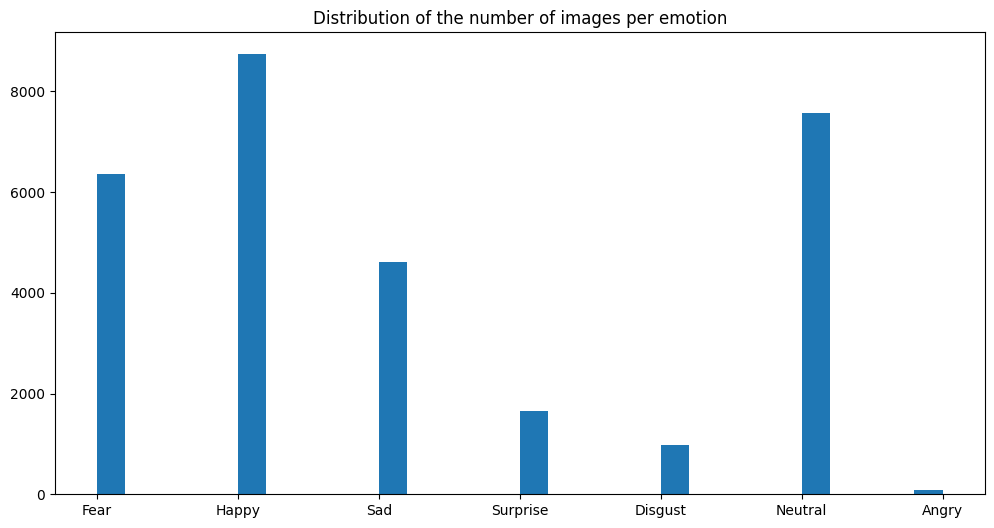

In [16]:
plt.figure(figsize=(12,6))
plt.hist(y_train, bins=30)
plt.title("Distribution of the number of images per emotion")
plt.show()

In [17]:
from imblearn.over_sampling import RandomOverSampler
import statistics

In [19]:
ros = RandomOverSampler(sampling_strategy= {'Angry': round(statistics.mean(y_train.value_counts())), 'Disgust': round(statistics.mean(y_train.value_counts())), 'Surprise': round(statistics.mean(y_train.value_counts()))})
X_ros, y_ros = ros.fit_resample(X_train, y_train)

In [20]:
y_ros.value_counts()

Happy       8737
Neutral     7578
Fear        6352
Sad         4605
Surprise    4286
Disgust     4286
Angry       4286
Name: sentiment, dtype: int64

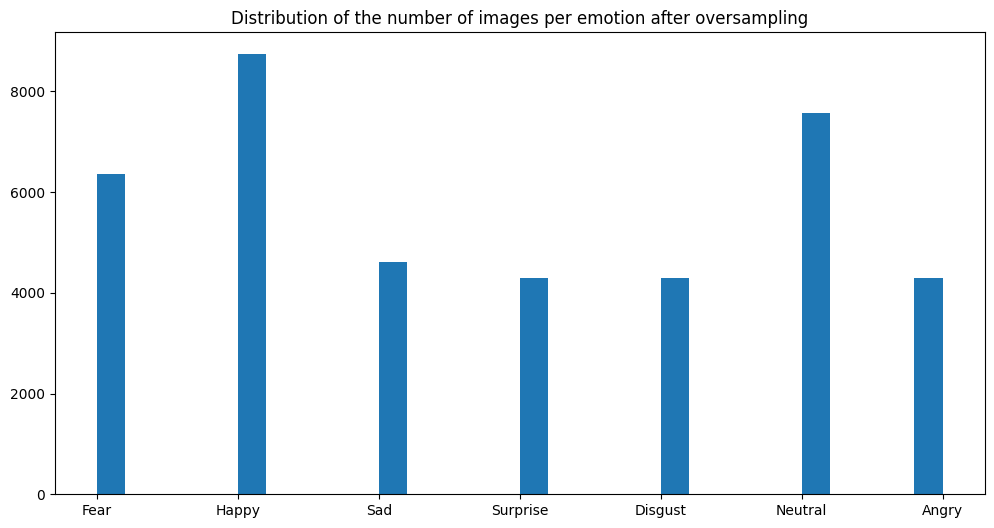

In [21]:
plt.figure(figsize=(12,6))
plt.hist(y_ros, bins=30)
plt.title("Distribution of the number of images per emotion after oversampling")
plt.show()

In [22]:
labels_train, features_train = [],[]

labels_train = pd.get_dummies(y_ros).values

dataset_train = X_ros

#converting content column in train and val set to text so as to convert any floating point/int content to str
features_train = dataset_train.content.astype(str).values

In [23]:
labels_val, features_val = [],[]

labels_val = pd.get_dummies(y_val).values

dataset_val = X_val

#converting content column in train and val set to text so as to convert any floating point/int content to str
features_val = dataset_val.content.astype(str).values

In [24]:
labels_train

array([[0, 0, 1, ..., 0, 0, 0],
       [0, 0, 1, ..., 0, 0, 0],
       [0, 0, 1, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 1],
       [0, 0, 0, ..., 0, 0, 1],
       [0, 0, 0, ..., 0, 0, 1]], dtype=uint8)

In [25]:
features_train

array(["This wind is crampin' my style. I have a section of my yard that won't get any water. I'd move the sprinkler, but it's surrounded by mud.",
       '@BonjourHoney Guilt trips, feeling sick, pressure. stress and too much drama',
       'tomorrow should be good. but apparently no movies', ...,
       '@juicystar007 Pleaseeee im really tired and stuck in waiting room for 2 hours  midnight in england. hw much money do u get a mnth?',
       'Revamping my recording studio today and adding some nice high end outboard gear...very exited!',
       "I was gonna get off at 230 2day. Just found out I'm stayin til 630"],
      dtype=object)

In [26]:
X_train = features_train
X_val = features_val
y_train = labels_train
y_val = labels_val

print("Input training features and label shape are {},{}".format(X_train.shape,y_train.shape))
print("Input validation features and label shape are {}, {}".format(X_val.shape,y_val.shape))

Input training features and label shape are (40130,),(40130, 7)
Input validation features and label shape are (10000,), (10000, 7)


In [27]:
bert_model_name_encoder = 'bert_en_uncased_L-12_H-768_A-12'
encoder_download_link = 'https://tfhub.dev/tensorflow/bert_en_uncased_L-12_H-768_A-12/3'
bert_model_name_preprocess = 'bert_en_uncased_L-12_H-768_A-12'
preprocess_download_link = 'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3'

In [28]:
print(f'BERT model selected           : {encoder_download_link}')
print(f'Preprocess model auto-selected: {preprocess_download_link}')

BERT model selected           : https://tfhub.dev/tensorflow/bert_en_uncased_L-12_H-768_A-12/3
Preprocess model auto-selected: https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3


In [29]:
bert_preprocessor = hub.KerasLayer(preprocess_download_link, name='preprocessing')
bert_encoder = hub.KerasLayer(encoder_download_link, name='BERT_encoder')

In [30]:
def classifier_model():
  text_input = Input(shape =(), dtype= tf.string, name='text')
  #preprocesing layer
  preprocessed_text = bert_preprocessor(text_input)
  #passing through encoder layer
  embeddings = bert_encoder(preprocessed_text)
  #fetching the pooled_output from the dictionary of outputs
  output = embeddings['pooled_output']
  #output = Dropout(0.2)(output)
  #passing through final dense layer
  output = Dense(7, activation='softmax', name='classifier_end')(output)
  return Model(text_input, output)
classifier = classifier_model()

In [31]:
classifier.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 text (InputLayer)              [(None,)]            0           []                               
                                                                                                  
 preprocessing (KerasLayer)     {'input_mask': (Non  0           ['text[0][0]']                   
                                e, 128),                                                          
                                 'input_type_ids':                                                
                                (None, 128),                                                      
                                 'input_word_ids':                                                
                                (None, 128)}                                                  

In [32]:
loss = CategoricalCrossentropy(from_logits=False)
metrics = CategoricalAccuracy()
optimizer = 'adam'

In [33]:
classifier.compile(optimizer = optimizer, loss=loss, metrics=metrics)

In [34]:
#fitting the model
history = classifier.fit(X_train,y_train, validation_data=(X_val,y_val), epochs=10)

Epoch 1/10
1255/1255 [==============================] - 591s 460ms/step - loss: 1.8314 - categorical_accuracy: 0.2742 - val_loss: 1.7623 - val_categorical_accuracy: 0.3306
Epoch 2/10
1255/1255 [==============================] - 578s 461ms/step - loss: 1.7449 - categorical_accuracy: 0.3203 - val_loss: 1.6312 - val_categorical_accuracy: 0.3758
Epoch 3/10
1255/1255 [==============================] - 577s 460ms/step - loss: 1.7134 - categorical_accuracy: 0.3357 - val_loss: 1.6189 - val_categorical_accuracy: 0.3795
Epoch 4/10
1255/1255 [==============================] - 577s 460ms/step - loss: 1.6910 - categorical_accuracy: 0.3448 - val_loss: 1.5991 - val_categorical_accuracy: 0.3749
Epoch 5/10
1255/1255 [==============================] - 578s 461ms/step - loss: 1.6723 - categorical_accuracy: 0.3572 - val_loss: 1.7265 - val_categorical_accuracy: 0.3516
Epoch 6/10
1255/1255 [==============================] - 580s 462ms/step - loss: 1.6607 - categorical_accuracy: 0.3598 - val_loss: 1.5685 - v

Text(0.5, 1.0, 'Accuracy Curves')

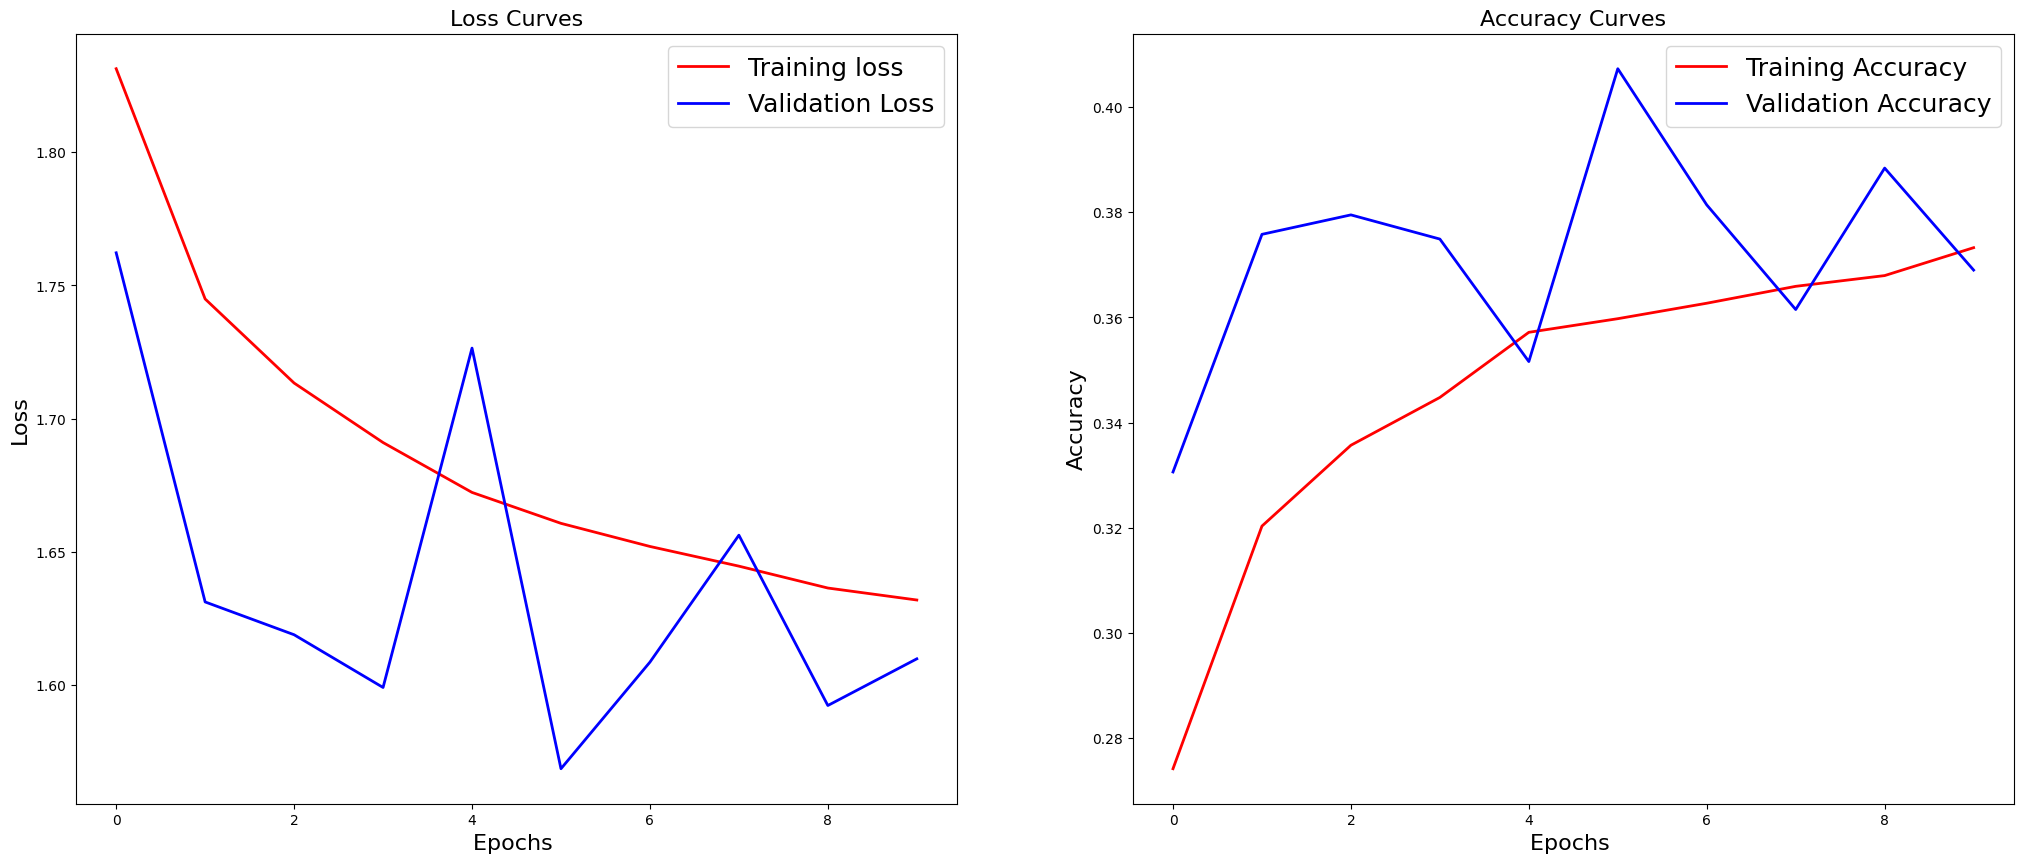

In [35]:
#Plotting accuracy and loss curves for the model

# Loss Curves
plt.figure(figsize=[25,10])
plt.subplot(1, 2, 1)
plt.plot(history.history['loss'],'r',linewidth=2.0)
plt.plot(history.history['val_loss'],'b',linewidth=2.0)
plt.legend(['Training loss', 'Validation Loss'],fontsize=18)
plt.xlabel('Epochs ',fontsize=16)
plt.ylabel('Loss',fontsize=16)
plt.title('Loss Curves',fontsize=16)

# Accuracy Curves
plt.subplot(1, 2, 2)
plt.plot(history.history['categorical_accuracy'],'r',linewidth=2.0)
plt.plot(history.history['val_categorical_accuracy'],'b',linewidth=2.0)
plt.legend(['Training Accuracy', 'Validation Accuracy'],fontsize=18)
plt.xlabel('Epochs ',fontsize=16)
plt.ylabel('Accuracy',fontsize=16)
plt.title('Accuracy Curves',fontsize=16)

In [36]:
#Saving Model

classifier.save('/content/drive/MyDrive/Emotion_Recognition/Text_ER/BERT_M.h5')
classifier.save_weights('/content/drive/MyDrive/Emotion_Recognition/Text_ER/BERT_W.h5')

In [5]:
#Load model

from keras.models import load_model
model_ter = tf.keras.models.load_model(('/content/drive/MyDrive/Emotion_Recognition/Text_ER/BERT_M.h5'), custom_objects={'KerasLayer':hub.KerasLayer})
model_ter.load_weights('/content/drive/MyDrive/Emotion_Recognition/Text_ER/BERT_W.h5')
print("Loaded model from disk")

Loaded model from disk


In [37]:
test_string1 = ["You look beautiful!"]
test_string2 = ["Today is a sunny day."]
test_string3 = ["This is the last day we see each other."]

def predict(test_string):
  class_prob = classifier.predict(test_string, batch_size=1)[0]
  if np.argmax(class_prob)==0:
    print("Angry")
  elif np.argmax(class_prob)==1:
    print("Disgust")
  elif np.argmax(class_prob)==2:
    print("Fear")
  elif np.argmax(class_prob)==3:
    print("Happy")
  elif np.argmax(class_prob)==4:
    print("Neutral")
  elif np.argmax(class_prob)==5:
    print("Sad")
  else:
    print("Surprise")

predict(test_string1)
predict(test_string2)
predict(test_string3)

1/1 [==============================] - 4s 4s/step
Happy
1/1 [==============================] - 0s 112ms/step
Happy
1/1 [==============================] - 0s 126ms/step
Sad
